## Practical about Feature Selection

#### Date: 10/04/2023
#### Author: Elena Aguayo Jara, Yiran Du

---
##### Import the required libraries and packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#### Import the dataset

In [3]:
data = pd.read_csv('prostate.csv')
X = data.values[ :, :-1].astype(np.float)
y = data.values[ :, -1 ].astype(np.int)
print(f'The data has {X.shape[1]} feature and {X.shape[0]} instances')

scaler = preprocessing.StandardScaler()
np.random.seed(0)

The data has 12625 feature and 102 instances


### Part 1 Feature selection
*In this practical, you will become familiarized with some basic feature selection methods implemented in scikit-learn. Consider the prostate dataset that is attached to this practical. You are asked to:*

*1. Estimate the performance of the nearest neighbor classifier on this dataset using 10-times 10-fold cross validation when all the features are used for prediction. The number of neighbors should be chosen using an inner cross-validation procedure. You can use 5-fold cross validation for this.*

In [4]:
# This is the number of times the 10-fold cv process will be repeated
n_repeats = 10

errors_knn = np.zeros(10 * n_repeats)
accuracy_knn  = np.zeros(10 * n_repeats)
tp_knn = np.zeros(10 * n_repeats)
tn_knn  = np.zeros(10 * n_repeats)

rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)
n_splits = rkf.get_n_splits()

for split, (train_index, test_index) in tqdm(enumerate(rkf.split(X, y)), total=n_splits, desc="Processing folds"):
   
    # First simple variable ranking
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data to have zero mean and unit std
    scaler.fit(X_train, y_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Create a Pipeline for training the classifier in the inner cross validation procedure
    pipeline = Pipeline([('knn', KNeighborsClassifier())])

    # Specify values for the hyperparameters of the classifier
    N_neighbors = np.arange(1, 31)
    param_grid = {'knn__n_neighbors': N_neighbors}

    # Stratified 5 fold cross-validation, to estimate the performance of the classifier
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train, y_train)
    accuracies = gridcv.cv_results_['mean_test_score']
    n_neighbors = N_neighbors[np.argmax(accuracies)]
    knn = KNeighborsClassifier(n_neighbors)

    # Fit the classifiers and compute the test performance
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    errors_knn[split] = 1.0 - np.mean(y_pred == y_test)
    
    conf = confusion_matrix(y_test, y_pred)
    # The matrix conf contains:
    # TN | FN
    # FP | TP
    TN = conf[0][0]
    TP = conf[1][1]
    FP = conf[0][1]
    FN = conf[1][0]
    
    accuracy_knn [split] = (TP + TN) / (TN + TP + FP + FN)
    tp_knn [split] = TP / (TP + FN)
    tn_knn [split] = TN / (TN + FP)

Processing folds: 100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


In [5]:
print('Mean Error is: %f' % np.mean(errors_knn))
print('Std Mean Error is: %f' % (np.std(errors_knn) / np.sqrt(len(errors_knn))))
print('Predicion accuracy is: %f' % np.mean(accuracy_knn))
print('True postive rate is: %f' % np.mean(tp_knn))
print('True negative rate is: %f\n' % np.mean(tn_knn))

Mean Error is: 0.217727
Std Mean Error is: 0.012379
Predicion accuracy is: 0.782273
True postive rate is: 0.794226
True negative rate is: 0.794583



*2. Estimate the performance of the nearest neighbor classifier on the same dataset when using a feature selection technique based on the F-score (ANOVA) that picks up the 10 most relevant features. Use the same cross-validation methods as in the previous step.*

In [6]:
# This is the number of times the 10-fold cv process will be repeated
n_repeats = 10

errors_knn = np.zeros(10 * n_repeats)
errors_knn_random = np.zeros(10 * n_repeats)
accuracy_knn  = np.zeros(10 * n_repeats)
tp_knn = np.zeros(10 * n_repeats)
tn_knn  = np.zeros(10 * n_repeats)

rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)
n_splits = rkf.get_n_splits()

for split, (train_index, test_index) in tqdm(enumerate(rkf.split(X, y)), total=n_splits, desc="Processing folds"):
   
    # First simple variable ranking
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data to have zero mean and unit std
    scaler.fit(X_train, y_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # This random array will be used to pick up features at random as a base-line to compare with.
    random_features = np.random.permutation(X.shape[1])

    # Create a Pipeline for training the classifier with 10 top features based on F-score
    selector = SelectKBest(score_func=f_classif, k=10)
    
    selector.fit(X_train, y_train)
        
    # Carry out the feature selection process
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
        
    # Specify values for the hyperparameters of the classifier
    N_neighbors = np.arange(1, 31)
    param_grid = {'knn__n_neighbors': N_neighbors}
    pipeline = Pipeline([('knn', KNeighborsClassifier())])
    # Stratified 5 fold cross-validation, to estimate the performance of the classifier
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train_sel, y_train)
    accuracies = gridcv.cv_results_['mean_test_score']
    n_neighbors = N_neighbors[np.argmax(accuracies)]
    knn = KNeighborsClassifier(n_neighbors)

    # Fit the classifiers and compute the test performance
    knn.fit(X_train_sel, y_train)
    y_pred = knn.predict(X_test_sel)    
    errors_knn[split] = 1.0 - np.mean(y_pred == y_test)

    # Fit the classifiers and compute the test performance for random features
    knn.fit(X_train[ :, random_features[:10]], y_train)
    errors_knn_random[split] = 1.0 - np.mean(knn.predict(X_test[ :, random_features[:10]]) == y_test)
    
    conf = confusion_matrix(y_test, y_pred)
    # The matrix conf contains:
    # TN | FN
    # FP | TP
    TN = conf[0][0]
    TP = conf[1][1]
    FP = conf[0][1]
    FN = conf[1][0]
    
    accuracy_knn [split] = (TP + TN) / (TN + TP + FP + FN)
    tp_knn [split] = TP / (TP + FN)
    tn_knn [split] = TN / (TN + FP)

Processing folds: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


In [12]:
print('Mean Error for 10 top features is: %f' % np.mean(errors_knn))
print('Std Mean Error for 10 top features is: %f' % (np.std(errors_knn) / np.sqrt(len(errors_knn))))
print('Mean Error for 10 random features is: %f' % np.mean(errors_knn_random))
print('Std Mean Error for 10 random features is: %f' % (np.std(errors_knn_random) / np.sqrt(len(errors_knn_random))))
print('Predicion accuracy for 10 top features is: %f' % np.mean(accuracy_knn))
print('True postive rate for 10 top features is: %f' % np.mean(tp_knn))
print('True negative rate for 10 top features is: %f\n' % np.mean(tn_knn))

Mean Error for 10 top features is: 0.087364
Std Mean Error for 10 top features is: 0.009132
Mean Error for 10 random features is: 0.338080
Std Mean Error for 10 random features is: 0.015639
Predicion accuracy for 10 top features is: 0.912636
True postive rate for 10 top features is: 0.914548
True negative rate for 10 top features is: 0.921107



*3. Repeat the previous experiment but when a random forest is used to pick up the 10 most relevant features. Use an initial filtering method based on the F-score to keep only the 20% most promising features.*

In [11]:
# This is the number of times the 10-fold cv process will be repeated
n_repeats = 10

errors_knn = np.zeros(10 * n_repeats)
accuracy_knn  = np.zeros(10 * n_repeats)
tp_knn = np.zeros(10 * n_repeats)
tn_knn  = np.zeros(10 * n_repeats)

rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)
n_splits = rkf.get_n_splits()

for split, (train_index, test_index) in tqdm(enumerate(rkf.split(X, y)), total=n_splits, desc="Processing folds"):
   
    # First, variable ranking
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data 
    scaler.fit(X_train, y_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Create a Pipeline for training the classifier with 20% top features based on F-score
    filtering = SelectKBest(score_func=f_classif, k = int(np.round(X.shape[ 1 ] * 0.2)))
    filtering.fit(X_train, y_train)
        
    # Carry out the top 20% features
    X_train = filtering.transform(X_train)
    X_test = filtering.transform(X_test)
    
    # Select the top 10 data using RF
    selector = SelectFromModel(RandomForestClassifier(n_estimators = 2000, \
        random_state = 0), threshold = 0.0)
    selector.fit(X_train, y_train)
    selector.threshold = -1.0 * np.sort(-1.0 * selector.estimator_.feature_importances_)[ 9 ]
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
        
    # Specify values for the hyperparameters of the classifier
    N_neighbors = np.arange(1, 31)
    param_grid = {'knn__n_neighbors': N_neighbors}
    pipeline = Pipeline([('knn', KNeighborsClassifier())])
    
    # Stratified 5 fold cross-validation, to estimate the performance of the classifier
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train_sel, y_train)
    accuracies = gridcv.cv_results_['mean_test_score']
    n_neighbors = N_neighbors[np.argmax(accuracies)]
    knn = KNeighborsClassifier(n_neighbors)

    # Fit the classifiers and compute the test performance
    knn.fit(X_train_sel, y_train)
    y_pred = knn.predict(X_test_sel)    
    errors_knn[split] = 1.0 - np.mean(y_pred == y_test)

    conf = confusion_matrix(y_test, y_pred)

    TN = conf[0][0]
    TP = conf[1][1]
    FP = conf[0][1]
    FN = conf[1][0]
    
    accuracy_knn [split] = (TP + TN) / (TN + TP + FP + FN)
    tp_knn [split] = TP / (TP + FN)
    tn_knn [split] = TN / (TN + FP)

Processing folds: 100%|██████████| 100/100 [08:10<00:00,  4.90s/it]


In [8]:
print('Mean Error for 10 top features chosen by RF is: %f' % np.mean(errors_knn))
print('Std Mean Error for 10 top features chosen by RF is: %f' % (np.std(errors_knn) / np.sqrt(len(errors_knn))))
print('Predicion accuracy for 10 top features chosen by RF is: %f' % np.mean(accuracy_knn))
print('True postive rate for 10 top features  chosen by RF is: %f' % np.mean(tp_knn))
print('True negative rate for 10 top features  chosen by RF is: %f\n' % np.mean(tn_knn))

Mean Error for 10 top features chosen by RF is: 0.087364
Std Mean Error for 10 top features chosen by RF is: 0.009132
Predicion accuracy for 10 top features chosen by RF is: 0.912636
True postive rate for 10 top features  chosen by RF is: 0.914548
True negative rate for 10 top features  chosen by RF is: 0.921107



*4. What feature selection method performs best? Can you explain why?*


According to the results obtained, it is observed that with Random Forest (RF) a higher accuracy is obtained (91%) compared to 78% where all the attributes have been used in the first section. Although it is true that the accuracy is similar between RF (performing F-score previously) and F-score without using RF, the average error using RF is slightly lower (0.087364) compared to F-score (0.089182). Furthermore, the false positive (FP) rate is higher using RF (0.914548) versus F-score (0.906143), and much higher than in the first section (0.794226). The same is true for the false negative (FN) rate.

The first case where all attributes have been used gives worse results since not all attributes have to be significant, thus adding noise to the result.

Random Forest gives better results because its attribute filtering is stricter (it starts from the 20% most relevant attributes and chooses 10). In addition, RF uses multiple precision trees to choose attributes, so this further increases accuracy and avoids overfitting; however, the computational cost is higher.

### Part 2 Analyzing the trade-off between interpretability and prediction accuracy
*Now we will address the problem of analyzing the trade-off between interpretability and prediction accuracy. For this, you are asked to:*

*1. Estimate the performance of the nearest neighbor classifier with K=3 as a function of the features used for prediction. Use a 10-times 10-fold cross-validation method and plot the results obtained. That is prediction error vs. the number of features used for prediction. Use the F-score for feature selection. Report results from 1 feature to 200 features. Not all features need to be explored. Use a higher resolution when you are closer to 1 feature.*

In [13]:
# This is the number of times the 10-fold cv process will be repeated
n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

# Use a higher resolution when you are closer to 1 feature
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(201), 0.1))).astype(np.int))

errors_knn = np.zeros((10 * n_repeats, len(n_features)))
errors_knn_random = np.zeros((10 * n_repeats, len(n_features)))

n_splits = rkf.get_n_splits()

for split, (train_index, test_index) in tqdm(enumerate(rkf.split(X, y)), total=n_splits, desc="Processing folds"):
   
    # First simple variable ranking
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data to have zero mean and unit std
    scaler.fit(X_train, y_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # This random array will be used to pick up features at random as a base-line to compare with.
    random_features = np.random.permutation(X.shape[1])
    
    # Loop over the number of features to be tested
    for i in range(len(n_features)):
        # Create a Pipeline for training the classifier with defined features based on F-score
        selector = SelectKBest(score_func=f_classif, k=n_features[len(n_features) - i - 1])
        selector.fit(X_train, y_train)
            
        # Carry out the feature selection process
        X_train_sel = selector.transform(X_train)
        X_test_sel = selector.transform(X_test)
            
        # Specify value for the hyperparameters of the classifier
        knn= KNeighborsClassifier(n_neighbors=3)

        # Fit the classifiers and compute the test performance
        knn.fit(X_train_sel, y_train)
        y_pred = knn.predict(X_test_sel)    
        errors_knn[split, len(n_features) - i - 1] = 1.0 - np.mean(y_pred == y_test)

        # Fit the classifiers and compute the test performance for random features
        knn.fit(X_train[:, random_features[: n_features[len(n_features) - i - 1]]], y_train)
        errors_knn_random[split, len(n_features) - i - 1] = 1.0 - np.mean(knn.predict(X_test[ :, random_features[:n_features[len(n_features) - i - 1]]]) == y_test)

Processing folds: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


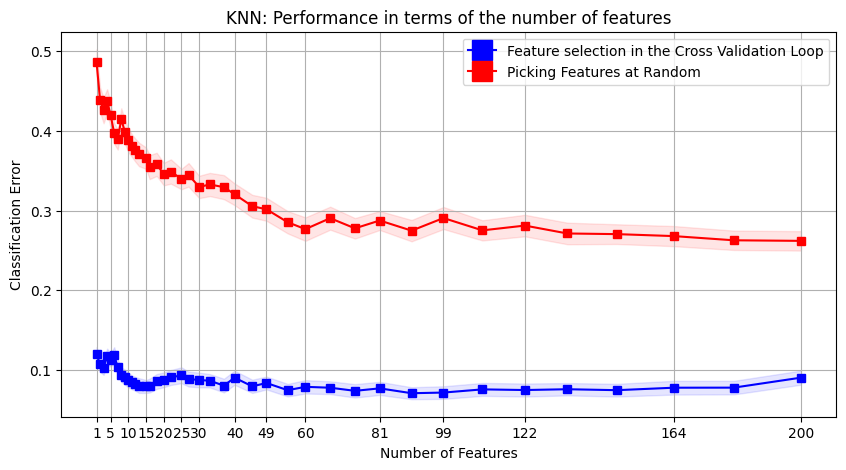

In [14]:
# Compute mean errors and the corresponding standard deviations
error = np.mean(errors_knn, 0)
error_std = np.std(errors_knn, 0) / np.sqrt(errors_knn.shape[ 0 ])

error_random = np.mean(errors_knn_random, 0)
error_random_std = np.std(errors_knn_random, 0) / np.sqrt(errors_knn_random.shape[ 0 ])

plt.figure(figsize=(10,5))
line1, = plt.plot(n_features, error, 's-', color="b")
line2, = plt.plot(n_features, error_random, 's-', color="r")
plt.fill_between(n_features, error - error_std, error + error_std, alpha=0.1, color="b")
plt.fill_between(n_features, error_random - error_random_std, \
    error_random + error_random_std, alpha=0.1, color="r")
plt.grid()
plt.title("KNN: Performance in terms of the number of features")
plt.xlabel('Number of Features')
plt.xticks(np.array([1, 5, 10, 15, 20, 25, 30, 40, 49, 60, 81, 99, 122, 164, 200]))
plt.ylabel('Classification Error')
legend_handles = [ mlines.Line2D([], [], color='b', marker='s', \
    markersize=15, label='Feature selection in the Cross Validation Loop'),
    mlines.Line2D([], [], color='r', marker='s', \
    markersize=15, label='Picking Features at Random') ]
plt.legend(handles=legend_handles, loc = 1)
plt.show()

*2. Repeat that process when the feature selection is done externally to the cross-validation loop using all the available data. Include these results in the previous plot.*

In [15]:
# This is the number of times the 10-fold cv process will be repeated
n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

# Use a higher resolution when you are closer to 1 feature
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(201), 0.1))).astype(np.int))

errors_knn_all = np.zeros((10 * n_repeats, len(n_features)))

n_splits = rkf.get_n_splits()

# Loop over the number of features to be chosen
for i in tqdm(range(len(n_features))):
    # Create a Pipeline for training the classifier with defined features based on F-score
    selector = SelectKBest(score_func=f_classif, k=n_features[len(n_features) - i - 1])
    selector.fit(X, y)
    
    # Carry out the feature selection process
    X_sel = selector.transform(X)
        
    for split, (train_index, test_index) in enumerate(rkf.split(X_sel, y)):
   
        # First simple variable ranking
        X_train, X_test = X_sel[train_index], X_sel[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # We standardize the data to have zero mean and unit std
        scaler.fit(X_train, y_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Specify value for the hyperparameters of the classifier
        knn= KNeighborsClassifier(n_neighbors=3)

        # Fit the classifiers and compute the test performance
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        errors_knn_all[split, len(n_features) - i - 1] = 1.0 - np.mean(y_pred == y_test)

100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


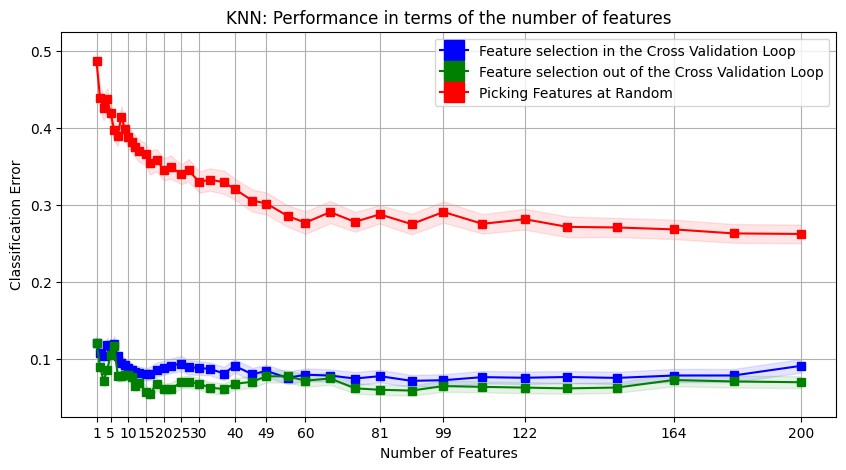

In [16]:
# Compute mean errors and the corresponding standard deviations
error_all = np.mean(errors_knn_all, 0)
error_all_std = np.std(errors_knn_all, 0) / np.sqrt(errors_knn_all.shape[ 0 ])

plt.figure(figsize=(10,5))
line1, = plt.plot(n_features, error, 's-', color="b")
line2, = plt.plot(n_features, error_all, 's-', color="g")
line3, = plt.plot(n_features, error_random, 's-', color="r")
plt.fill_between(n_features, error - error_std, error + error_std, alpha=0.1, color="b")
plt.fill_between(n_features, error_all - error_all_std,  \
    error_all + error_all_std, alpha=0.1, color="g")
plt.fill_between(n_features, error_random - error_random_std, \
    error_random + error_random_std, alpha=0.1, color="r")
plt.grid()
plt.title("KNN: Performance in terms of the number of features")
plt.xlabel('Number of Features')
plt.xticks(np.array([1, 5, 10, 15, 20, 25, 30, 40, 49, 60, 81, 99, 122, 164, 200]))
plt.ylabel('Classification Error')
#plt.ylim(0.0,  0.5)
legend_handles = [ mlines.Line2D([], [], color='b', marker='s', \
    markersize=15, label='Feature selection in the Cross Validation Loop'),
    mlines.Line2D([], [], color='g', marker='s', \
    markersize=15, label='Feature selection out of the Cross Validation Loop'),
    mlines.Line2D([], [], color='r', marker='s', \
    markersize=15, label='Picking Features at Random') ]
plt.legend(handles=legend_handles, loc = 1)
plt.show()

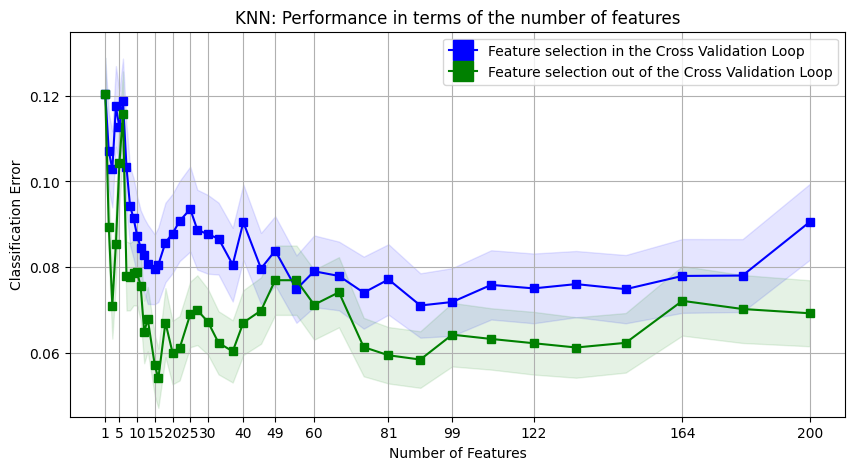

In [165]:
plt.figure(figsize=(10,5))
line1, = plt.plot(n_features, error, 's-', color="b")
line2, = plt.plot(n_features, error_all, 's-', color="g")
plt.fill_between(n_features, error - error_std, error + error_std, alpha=0.1, color="b")
plt.fill_between(n_features, error_all - error_all_std,  \
    error_all + error_all_std, alpha=0.1, color="g")
plt.grid()
plt.title("KNN: Performance in terms of the number of features")
plt.xlabel('Number of Features')
plt.xticks(np.array([1, 5, 10, 15, 20, 25, 30, 40, 49, 60, 81, 99, 122, 164, 200]))
plt.ylabel('Classification Error')
plt.ylim(0.045,  0.135)
legend_handles = [ mlines.Line2D([], [], color='b', marker='s', \
    markersize=15, label='Feature selection in the Cross Validation Loop'),
    mlines.Line2D([], [], color='g', marker='s', \
    markersize=15, label='Feature selection out of the Cross Validation Loop')]
plt.legend(handles=legend_handles, loc = 1)
plt.show()

*3. Are the two estimates obtained similar? What are their differences? If they are different try to explain why this is the case.*

As can be seen in the graph above, the results are similar, but it is more optimal to select attributes outside the cross-validation loop (lower mean error and lower std error).

These results may be due to the fact that using all possible data outside the cross validation process provides more cases and, therefore, increases the possibility of finding the most relevant features.

*4. By taking a look at these results, what is the optimal number of features to use in this dataset in terms of interpretability vs. prediction error?*

In [17]:
# Feature selection out of the Cross Validation Loop
print('The optimal number of features according to the feature selection in all data is: %i' % n_features[np.argmin(error_all)])
print('The mean of the error in this case is: %f' % error_all[np.argmin(error_all)])
print('The std of the error in this case is: %f' % error_all_std[np.argmin(error_all)])

The optimal number of features according to the feature selection in all data is: 16
The mean of the error in this case is: 0.054000
The std of the error in this case is: 0.006917


After comparing the two methods, we use the Feature selection  out of the Cross Validation Loop method to select the features.
Base on what we tested above, the optimal number of features is 16. 
However, due to the fact that when we choose the value for the test we didn't choose all the features due to the cost of time, therefore, there might be other number of features arount 16 (specificly, we didn't test 17) If we want to make sure 16 is what we are looking, we could run again this part of code with only 16 and 17 to see which has a better performence.

In [19]:
# This is the number of times the 10-fold cv process will be repeated
n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

# Use a higher resolution when you are closer to 1 feature
n_features = np.arange(16, 18).astype(np.int)

errors_knn_special = np.zeros((10 * n_repeats, len(n_features)))

n_splits = rkf.get_n_splits()

# Loop over the number of features to be chosen
for i in tqdm(range(len(n_features))):
    # Create a Pipeline for training the classifier with defined features based on F-score
    selector = SelectKBest(score_func=f_classif, k=n_features[len(n_features) - i - 1])
    selector.fit(X, y)
    
    # Carry out the feature selection process
    X_sel = selector.transform(X)
        
    for split, (train_index, test_index) in enumerate(rkf.split(X_sel, y)):
   
        # First simple variable ranking
        X_train, X_test = X_sel[train_index], X_sel[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # We standardize the data to have zero mean and unit std
        scaler.fit(X_train, y_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Specify value for the hyperparameters of the classifier
        knn= KNeighborsClassifier(n_neighbors=3)

        # Fit the classifiers and compute the test performance
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        errors_knn_special[split, len(n_features) - i - 1] = 1.0 - np.mean(y_pred == y_test)



100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


In [20]:
# Compute mean errors and the corresponding standard deviations
error_special = np.mean(errors_knn_special, 0)
error_special_std = np.std(errors_knn_special, 0) / np.sqrt(errors_knn_special.shape[ 0 ])

# Feature selection out of the Cross Validation Loop
print('The optimal number of features according to the feature selection in all data is: %i' % n_features[np.argmin(error_special)])
print('The mean of the error in this case is: %f' % error_special[np.argmin(error_special)])
print('The std of the error in this case is: %f' % error_special_std[np.argmin(error_special)])

The optimal number of features according to the feature selection in all data is: 16
The mean of the error in this case is: 0.054000
The std of the error in this case is: 0.006917


Now we can say that the optimal number of features we are looking for is 16.

*5. Given the results obtained in this part of the practical, you are asked to indicate which particular features should be used for prediction on this dataset. Include a list with them. Take a look at the documentation of SelectKBest from scikit-learn to understand how to do this. Use all available data to provide such a list of features.*

In [21]:
n_features = 16

# Create a Pipeline for training the classifier with defined features based on F-score
selector = SelectKBest(score_func=f_classif, k=n_features)
selector.fit(X, y)
    
# Carry out the feature selection process
X_sel = selector.transform(X)

selected_features_indices = selector.get_support(indices=True)
selected_features = data.columns[selected_features_indices]
selected_features_list = list(selected_features)
print(f'The 16 selected features are: {selected_features_list}')

The 16 selected features are: ['1831_at', '32598_at', '34730_g_at', '35277_at', '36495_at', '37366_at', '37639_at', '38028_at', '38057_at', '38634_at', '39315_at', '39939_at', '40024_at', '41468_at', '496_s_at', '837_s_at']
